In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt
import anndata
import sys
sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/utils')
from sdmbench import compute_ARI, compute_NMI, compute_CHAOS, compute_PAS, compute_ASW, compute_HOM, compute_COM

import time
import psutil
import tracemalloc

from SpaceFlow import SpaceFlow

def evaluate_clustering(adata: sc.AnnData, df_meta, time_taken: float, memory_used: float, output_dir: str) -> dict:
    """Evaluate clustering using sdmbench"""
    gt_key = 'ground_truth'
    pred_key = 'pred'
    adata.obs['ground_truth'] = df_meta['layer_guess'].values
    adata = adata[~pd.isnull(adata.obs['ground_truth'])]
    
    results = {
        "ARI": compute_ARI(adata, gt_key, pred_key),
        "AMI": compute_NMI(adata, gt_key, pred_key),
        "Homogeneity": compute_HOM(adata, gt_key, pred_key),
        "Completeness": compute_COM(adata, gt_key, pred_key),
        "ASW": compute_ASW(adata, pred_key),
        "CHAOS": compute_CHAOS(adata, pred_key),
        "PAS": compute_PAS(adata, pred_key),
        "Time": time_taken,
        "Memory": memory_used
    }
    
    df_results = pd.DataFrame([results])
    df_results.to_csv(os.path.join(output_dir, "metrics.csv"), index=False)
    return results

BASE_PATH = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/data/DLPFC')
output_path = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/results2/DLPFC/SpaceFlow')

sample_list = ['151507', '151508', '151509', '151510', 
                '151669', '151670', '151671', '151672', 
                '151673', '151674', '151675', '151676']

sample = sample_list[8]

In [2]:
print(f"================ Start Processing {sample} ======================")
dir_input = Path(f'{BASE_PATH}/{sample}/')
dir_output = Path(f'{output_path}/{sample}/')
dir_output.mkdir(parents=True, exist_ok=True)

if sample in ['151669', '151670', '151671', '151672']:
    n_clusters = 5
else:
    n_clusters = 7

start_time = time.time()
tracemalloc.start()

adata = sc.read_visium(dir_input)
adata.var_names_make_unique()
gt_df = pd.read_csv(dir_input / 'metadata.tsv', sep='\t')
adata.obs['layer_guess'] = gt_df['layer_guess']

sc.pp.filter_genes(adata, min_cells=3)

sf = SpaceFlow.SpaceFlow(adata=adata)
sf.preprocessing_data(n_top_genes=3000)

sf.train(
    spatial_regularization_strength=0.1,
    z_dim=50,
    lr=1e-3,
    epochs=1000,
    max_patience=50,
    min_stop=100,
    random_seed=42,
    gpu=1,
    regularization_acceleration=True,
    edge_subset_sz=1000000,
    embedding_save_filepath=os.path.join(dir_output, "low_dim_data.csv"),
)

================ Start Processing 151673 ======================


/home/lytq/.conda/envs/spaceflow_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lytq/.conda/envs/spaceflow_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Epoch 2/1000, Loss: 1.5319384336471558
Epoch 12/1000, Loss: 1.3552136421203613
Epoch 22/1000, Loss: 0.9476900696754456
Epoch 32/1000, Loss: 0.6381539106369019
Epoch 42/1000, Loss: 0.4767533838748932
Epoch 52/1000, Loss: 0.34556844830513
Epoch 62/1000, Loss: 0.2714735269546509
Epoch 72/1000, Loss: 0.2506716251373291
Epoch 82/1000, Loss: 0.22542157769203186
Epoch 92/1000, Loss: 0.20561805367469788
Epoch 102/1000, Loss: 0.1836715042591095
Epoch 112/1000, Loss: 0.15525192022323608
Epoch 122/1000, Loss: 0.15888729691505432
Epoch 132/1000, Loss: 0.1715228259563446
Epoch 142/1000, Loss: 0.16880717873573303
Epoch 152/1000, Loss: 0.1537638008594513
Epoch 162/1000, Loss: 0.155238077044487
Epoch 172/1000, Loss: 0.10508796572685242
Epoch 182/1000, Loss: 0.1152411624789238
Epoch 192/1000, Loss: 0.10789191722869873
Epoch 202/1000, Loss: 0.09899923205375671
Epoch 212/1000, Loss: 0.09277969598770142
Epoch 222/1000, Loss: 0.09506155550479889
Epoch 232/1000, Loss: 0.07777519524097443
Epoch 242/1000, Los

array([[ 1.1963105 ,  2.5689518 , -0.40746194, ...,  2.6199002 ,
        -0.26593366, -0.89242697],
       [ 1.5956764 ,  2.3804579 , -0.41445702, ...,  3.6404235 ,
        -0.39152166, -0.56539303],
       [-0.18564977,  2.884842  ,  0.18069755, ...,  3.9619362 ,
         1.6794841 , -0.8027067 ],
       ...,
       [-0.31151155,  3.547205  ,  0.8179748 , ...,  2.2878    ,
         2.5739362 , -0.45024306],
       [-0.28290054,  2.9636126 ,  0.50812006, ...,  2.3674197 ,
         2.0303335 , -0.35473892],
       [ 1.1602056 ,  2.0245893 , -0.30355415, ...,  2.2574172 ,
        -0.3775319 , -0.8959225 ]], dtype=float32)

In [16]:
embedding = anndata.AnnData(sf.embedding)
sc.pp.neighbors(embedding, n_neighbors=50, use_rep='X')

for res in sorted(list(np.arange(0.2, 0.5, 0.01)), reverse=True):
    sc.tl.leiden(embedding, resolution=res)
    
    if len(pd.DataFrame(embedding.obs['leiden']).leiden.unique()) == n_clusters:
        print(f"Resolution: {res}")
        break

sf.segmentation(domain_label_save_filepath=os.path.join(dir_output, "domain_labels.csv"),
                n_neighbors=50,
                resolution=res)

sc.pp.neighbors(adata, n_neighbors=50)
sc.tl.umap(adata)

Resolution: 0.2900000000000001
Performing domain segmentation
Segmentation complete, domain labels of cells or spots saved at /home/lytq/Spatial-Transcriptomics-Benchmark/results2/DLPFC/SpaceFlow/151673/domain_labels.csv !


In [17]:
pred = pd.read_csv(os.path.join(dir_output, "domain_labels.csv"), header=None)
adata.obs['pred'] = pred.values
adata.obs

,in_tissue,array_row,array_col,layer_guess,leiden,pred,ground_truth
AAACAAGTATCTCCCA-1,1,50,102,Layer3,2,0,Layer3
AAACAATCTACTAGCA-1,1,3,43,Layer1,0,0,Layer1
AAACACCAATAACTGC-1,1,59,19,WM,4,4,WM
AAACAGAGCGACTCCT-1,1,14,94,Layer3,0,0,Layer3
AAACAGCTTTCAGAAG-1,1,43,9,Layer5,0,3,Layer5
...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,WM,4,4,WM
TTGTTTCATTAGTCTA-1,1,60,30,WM,4,4,WM
TTGTTTCCATACAACT-1,1,45,27,Layer6,3,3,Layer6
TTGTTTGTATTACACG-1,1,73,41,WM,3,4,WM


In [18]:
end_time = time.time()
time_taken = end_time - start_time
current, peak = tracemalloc.get_traced_memory()
memory_used = peak / (1024 ** 2)
tracemalloc.stop()

metrics = evaluate_clustering(adata, gt_df, time_taken, memory_used, dir_output)

In [7]:
adata.obs

,in_tissue,array_row,array_col,layer_guess,leiden,pred,ground_truth
AAACAAGTATCTCCCA-1,1,50,102,Layer3,6,4,Layer3
AAACAATCTACTAGCA-1,1,3,43,Layer1,0,11,Layer1
AAACACCAATAACTGC-1,1,59,19,WM,4,0,WM
AAACAGAGCGACTCCT-1,1,14,94,Layer3,6,4,Layer3
AAACAGCTTTCAGAAG-1,1,43,9,Layer5,0,3,Layer5
...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,WM,4,0,WM
TTGTTTCATTAGTCTA-1,1,60,30,WM,4,0,WM
TTGTTTCCATACAACT-1,1,45,27,Layer6,3,6,Layer6
TTGTTTGTATTACACG-1,1,73,41,WM,3,6,WM


In [22]:
adata

AnnData object with n_obs × n_vars = 3639 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'layer_guess', 'leiden', 'pred', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'layer_guess_colors', 'ground_truth_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [26]:
adata.obs["pred"] = adata.obs["pred"].astype("category")  # Convert to categorical


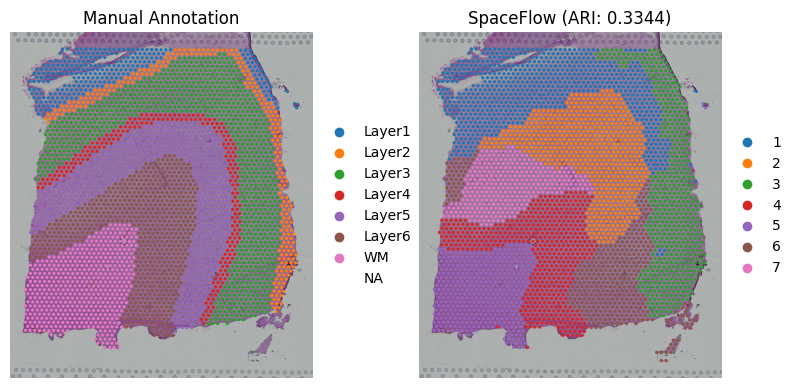

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, color='layer_guess', ax=axes[0], show=False)
sc.pl.spatial(adata, color='pred', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title(f'SpaceFlow (ARI: {metrics["ARI"]:.4f})')
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [str(int(label) + 1) if label.isdigit() else label for label in labels]
axes[1].legend(handles, new_labels, loc='center left', frameon=False, bbox_to_anchor=(1, 0.5))
for ax in axes:
    ax.axis('off')
plt.tight_layout()

plt.show()


In [9]:
adata

AnnData object with n_obs × n_vars = 3639 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'layer_guess', 'leiden', 'pred', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'ground_truth_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/lytq/.conda/envs/spaceflow_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lytq/.conda/envs/spaceflow_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


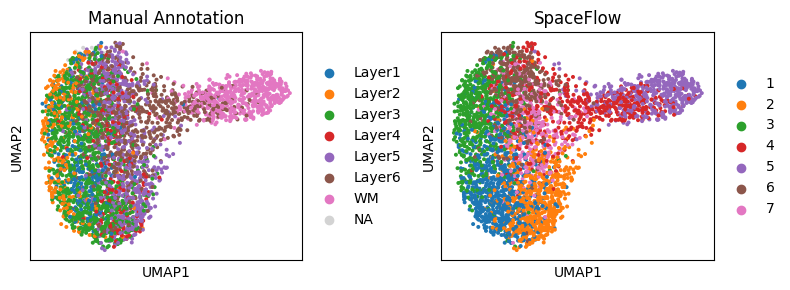

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sc.pl.umap(adata, color='ground_truth', ax=ax[0], show=False)
sc.pl.umap(adata, color='pred', ax=ax[1], show=False)
ax[0].set_title('Manual Annotation')
ax[1].set_title('SpaceFlow')
handles, labels = ax[1].get_legend_handles_labels()
new_labels = [str(int(label) + 1) if label.isdigit() else label for label in labels]
ax[1].legend(handles, new_labels, loc='center left', frameon=False, bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [13]:
embedding_df = pd.DataFrame(sf.embedding, index=adata.obs_names) 

In [14]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
AAACAAGTATCTCCCA-1,0.764950,0.202593,-0.394739,3.361319,1.286946,-0.149119,0.555085,1.658983,-0.120837,-0.012482,...,1.308366,-0.495084,-0.146739,-0.118524,-0.075879,1.041437,0.556151,2.019163,-0.262698,-0.758548
AAACAATCTACTAGCA-1,1.325873,0.109375,-0.472822,3.576828,0.716217,-0.232762,0.828085,2.596137,-0.097854,-0.025444,...,1.133423,-0.389467,-0.118939,-0.297167,-0.181640,0.081419,0.968964,2.788290,-0.466792,-0.577036
AAACACCAATAACTGC-1,-0.725487,1.514232,1.924367,3.510282,2.122701,-0.443934,1.757650,2.528129,0.269499,5.153647,...,1.051563,-0.860372,-0.122813,5.395898,0.309641,1.270623,-1.182962,3.961914,6.752015,-0.649418
AAACAGAGCGACTCCT-1,0.819307,0.127833,-0.327870,3.049589,1.091018,-0.117751,0.536577,1.651145,-0.059421,-0.039275,...,1.043761,-0.425759,-0.117364,-0.160800,-0.082022,0.601264,0.593107,1.938132,-0.348604,-0.696100
AAACAGCTTTCAGAAG-1,-0.180796,0.729819,-0.148439,2.430007,1.771596,-0.266398,0.147871,1.028536,-0.028592,1.897948,...,1.682482,-0.592209,-0.130369,1.238256,0.260723,2.258235,-0.000414,1.773412,2.398239,-0.321686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,-0.716181,0.925812,2.145453,2.906930,2.140231,-0.312746,1.413130,2.775012,-0.043739,4.762552,...,0.880919,-0.828925,-0.266063,5.792246,-0.106959,1.508643,-1.212417,3.225343,5.683925,-0.750020
TTGTTTCATTAGTCTA-1,-0.651152,1.406723,1.340662,3.952043,2.287838,-0.424696,1.729209,3.022816,-0.017259,5.674329,...,1.302233,-0.854281,-0.179274,4.988940,-0.104530,1.808002,-1.102238,4.441609,6.113206,-0.671389
TTGTTTCCATACAACT-1,-0.536981,1.320188,1.056189,2.672930,1.916412,-0.306804,0.870720,2.399024,-0.072451,3.289349,...,1.489239,-0.573450,-0.138326,3.692024,-0.019478,2.128916,-0.569997,2.610728,4.497241,-0.313170
TTGTTTGTATTACACG-1,-0.504921,1.610202,0.842257,2.616335,2.096324,-0.372116,1.040686,2.741214,-0.110061,3.884728,...,1.756223,-0.538329,-0.072048,3.226058,-0.096145,1.957238,-0.617827,2.928563,4.166171,-0.258838
